In [1]:
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import json
import help_functions as hf
import numpy as np
import time
hf.setup_gpu(gpu_nr=0)

2 Physical GPUs, 1 Logical GPU


In [2]:
tf.__version__

'2.3.0'

In [20]:
config_nr = 20
with open('training_configurations.json', 'r') as fp:
    config = json.load(fp)[str(config_nr)]

config['batch_size'] = 32


train, _ = hf.get_flow(df_file=config['data_folder'] + '/train_df.json.bz2',
                       # nr_classes=config['nr_classes'],
                       nr_classes=29,
                       batch_size=config['batch_size'],
                       image_dimension=config['image_dimension'])

val, _ = hf.get_flow(df_file=config['data_folder'] + '/val_stop_df.json.bz2',
                     nr_classes=config['nr_classes'],
                     batch_size=config['batch_size'],
                     image_dimension=config['image_dimension'])

Found 760000 non-validated image filenames belonging to 30 classes.


/home/matvieir/wiki_image_classification/src/classification/help_functions.py:269: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x_labels['labels'] = df['labels'].apply(lambda labels_list: [label for label in labels_list if label in top_classes])


Found 537192 validated image filenames belonging to 29 classes.
Found 50000 validated image filenames belonging to 29 classes.


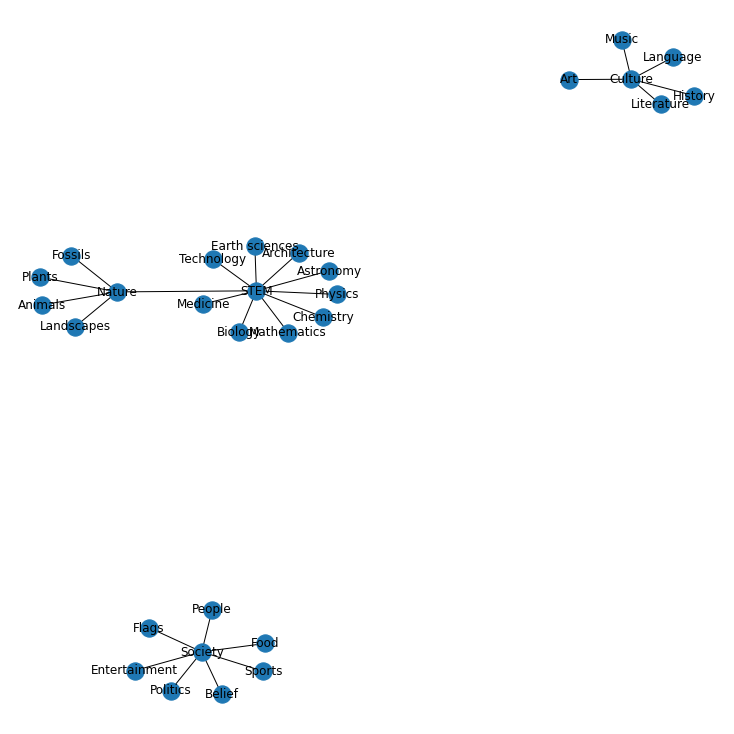

In [21]:
# M_ij = 1 if the class j is a subclass of the class i. I.e.: row i, column j is 1.
# - note that if M_ij is 1 then M_ji is necessarily 0 as the subclass relation is not reflexive
# - note that M_ij is also 1 if j is not a direct descendant of i 

#                 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
# mask = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 0
#                  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 1
#                  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 2
#                  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 3
#                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 4
#                  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 5
#                  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 6
#                  [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 7 Culture
#                  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 8
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 9
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 10
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 11
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 12
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 13
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 14
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 15
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 16
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 17
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 18
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 19
#                  [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1], # 20 Nature
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], # 21
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], # 22
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], # 23
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], # 24
#                  [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0], # 25 STEM
#                  [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0], # 26 Society
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], # 27
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], # 28
#                  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # 29 Weather
#                  ], dtype=np.float32)


# 29 classes, not including weather
#                 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28
mask = np.array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 0
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 1
                 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 2
                 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 3
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 4
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 5
                 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 6
                 [0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 7 Culture
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 8
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 9
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 10
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 11
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 12
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 13
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 14
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 15
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 16
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 17
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 18
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # 19
                 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], # 20 Nature
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], # 21
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], # 22
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], # 23
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], # 24
                 [0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1], # 25 STEM
                 [0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0], # 26 Society
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], # 27
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], # 28
                 ], dtype=np.float32)

import networkx as nx
import matplotlib.pyplot as plt
G = nx.from_numpy_matrix(mask)
plt.figure(figsize=(10, 10))
label_dict = {v: k for k, v in train.class_indices.items()}
nx.draw(G, labels=label_dict)

In [31]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
m = tf.keras.metrics.Accuracy()

class HierarchicalModel(keras.Model):

    def __init__(self, nr_labels, adj_matrix):
        super(HierarchicalModel, self).__init__()
        self.nr_labels = nr_labels
        self.adj_matrix = adj_matrix
        self.basemodel = EfficientNetB2(include_top=False, 
                                        weights=None, 
                                        classes=nr_labels, 
                                        input_shape=(config['image_dimension'], config['image_dimension'], 3))

    def call(self, inputs, training=None):
        x = self.basemodel(inputs)
        x = layers.Flatten()(x)
        x = layers.Dense(128, activation='relu')(x)
        outputs = layers.Dense(self.nr_labels, activation='sigmoid')(x)
        if training:
            return outputs
        else:
            return self.max_constrain(outputs)

    # @tf.function
    def max_constrain(self, output):
        """
        Constrains the output given the hierarchy expressed by the mask.
        """
        batch_size = tf.shape(output)[0]
        output = tf.expand_dims(output, axis=1) # Pytorch unsqueeze()
        batch_output = tf.broadcast_to(output,            [batch_size, self.nr_labels, self.nr_labels]) # this is H in the MCM equation
        batch_mask   = tf.broadcast_to(self.adj_matrix,   [batch_size, self.nr_labels, self.nr_labels])
        constrained_output = tf.math.reduce_max(batch_output * batch_mask, axis=2)
        return constrained_output

    # @tf.function   # to speed up: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#speeding-up_your_training_step_with_tffunction
    def train_step(self, inputs, labels):
        """
        Applies the hierarchy constraint module, calculates the loss function value,
        computes the gradients and optimizes the weights.
        """
        # inputs, labels = data
        with tf.GradientTape() as tape:
            y_probs = self(inputs, training=True)
            y_probs_constrained = (1 - labels) * self.max_constrain(y_probs) + \
                                    labels * self.max_constrain(labels * y_probs)
            # loss_value = self.compiled_loss(labels, y_probs_constrained)
            loss_value = self.compiled_loss(labels, y_probs_constrained)
            loss_value = bce(labels, y_probs_constrained)
        grads = tape.gradient(loss_value, self.trainable_weights)
        
        # return {m.name: m.result() for m in self.metrics}
        return grads, loss_value
        

In [32]:
model = HierarchicalModel(nr_labels=len(train.class_indices), adj_matrix=mask)
model.compile(optimizer=tf.keras.optimizers.Adam())
# model.fit(train, epochs=2, validation_data=val)

Epoch 1/2


ValueError: in user code:

    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    <ipython-input-31-2307fd3f4c6f>:18 call  *
        x = layers.Dense(128, activation='relu')(x)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:982 __call__  **
        self._maybe_build(inputs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2643 _maybe_build
        self.build(input_shapes)  # pylint:disable=not-callable
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/layers/core.py:1171 build
        self.kernel = self.add_weight(
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:597 add_weight
        variable = self._add_variable_with_custom_getter(
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/training/tracking/base.py:745 _add_variable_with_custom_getter
        new_variable = getter(
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer_utils.py:133 make_variable
        return tf_variables.VariableV1(
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:260 __call__
        return cls._variable_v1_call(*args, **kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:206 _variable_v1_call
        return previous_getter(
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2857 creator
        return next_creator(**kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/ops/variables.py:67 getter
        return captured_getter(captured_previous, **kwargs)
    /home/matvieir/anaconda3/lib/python3.8/site-packages/tensorflow/python/eager/def_function.py:701 invalid_creator_scope
        raise ValueError(

    ValueError: tf.function-decorated function tried to create variables on non-first call.


In [4]:
nr_labels = len(train.class_indices)
basemodel = EfficientNetB2(include_top=False, weights=None, classes=nr_labels, input_shape=(config['image_dimension'], config['image_dimension'], 3))
inputs = Input(shape=(config['image_dimension'], config['image_dimension'], 3))
x = basemodel(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(nr_labels, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [6]:
# @tf.function
# def max_constrain(output, mask):
#     """
#     Constrains the output given the hierarchy expressed by the mask.
#     """

#     batch_size = len(output) # or output.shape[0]

#     output = tf.expand_dims(output, axis=1) # Pytorch unsqueeze()

#     batch_output = tf.broadcast_to(output, [batch_size, nr_labels, nr_labels]) # this is H in the MCM equation
#     batch_mask   = tf.broadcast_to(mask,   [batch_size, nr_labels, nr_labels])

#     constrained_output = tf.math.reduce_max(batch_output * batch_mask, axis=2)

#     return constrained_output

# @tf.function   # to speed up: https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch#speeding-up_your_training_step_with_tffunction
# def train_step(inputs, labels, mask):
#     """
#     Applies the hierarchy constraint module, calculates the loss function value,
#     computes the gradients and optimizes the weights.
#     """

#     # print(f'INPUTS: \n{inputs}')
#     # print(f'LABELS: \n{labels}')

#     with tf.GradientTape() as tape:
#         y_probs = model(inputs, training=True)

#         # Extra steps for coherent HMC:
#         # 1. max constraint module        
#         # term_1 = (1 - labels) * max_constrain(y_probs, mask)
#         # term_2 = labels * max_constrain(labels * y_probs, mask)
#         # y_probs_constrained = term_1 + term_2
#         y_probs_constrained = (1 - labels) * max_constrain(y_probs, mask) + labels * max_constrain(labels * y_probs, mask)

#         # 2. modify what is sent to binary cross-entropy function
#         loss_value = model.compiled_loss(labels, y_probs_constrained)

#     grads = tape.gradient(loss_value, model.trainable_weights)
    
#     return loss_value, grads

In [28]:
epochs = 2
steps_per_epoch_train = len(train.classes) // config['batch_size'] + 1
steps_per_epoch_val = len(val.classes) // config['batch_size'] + 1
print(f'steps_per_epoch_train: {steps_per_epoch_train}.')
print(f'steps_per_epoch_val: {steps_per_epoch_val}.')
mask_tf = tf.convert_to_tensor(mask)

train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(epochs):
    print(f'Start of epoch {epoch}\n')
    end = time.time()

    train_loss = tf.metrics.Mean('train_loss')
    train_acc = tf.metrics.CategoricalAccuracy('train_accuracy')
    val_loss = tf.metrics.Mean('val_loss')
    val_acc = tf.metrics.CategoricalAccuracy('val_accuracy')
    
    for step, (x_batch_train, y_batch_train) in enumerate(train):
        if step >= steps_per_epoch_train:
            break
        # Calculate loss and gradients, then optimize parameters
        loss, grads = model.train_step(x_batch_train, y_batch_train)
        model.optimizer.apply_gradients(zip(grads, model.trainable_weights))

        train_loss.update_state(loss)
        train_acc.update_state(y_batch_train, model(x_batch_train, training=True))

        # Progress logging
        if step % 10 == 0:
            print(f"Training loss (for one batch) at step {step}: {float(loss):.4f}")
            print(f"Seen so far: {(step + 1) * config['batch_size']} samples")
            temp_end = time.time()
            print(f'time: {np.round((temp_end-end) / 60, 2)} minutes')
            end = time.time()      
        

    # Evaluate on validation set
    print('Evaluating on validation set...')
    for step, (x_batch_val, y_batch_val) in enumerate(val):
        if step >= steps_per_epoch_val:
            break
        loss, _ = model.train_step(x_batch_val, y_batch_val)
        val_loss.update_state(loss)
        val_acc.update_state(y_batch_val, model(x_batch_val, training=False))
    
    train_losses.append(train_loss.result().numpy())
    train_accs.append(train_acc.result().numpy())
    val_losses.append(val_loss.result().numpy())
    val_accs.append(val_acc.result().numpy())

    print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Accuracy: {100*train_accs[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {100*val_accs[-1]:.2f}%')

    # Reset training metrics at the end of each epoch
    train_loss.reset_states()
    train_acc.reset_states()
    val_loss.reset_states()
    val_acc.reset_states()

steps_per_epoch_train: 16788.
steps_per_epoch_val: 1563.
Start of epoch 0



AttributeError: 'list' object has no attribute 'numpy'

In [8]:
d = {'epoch': list(range(0, epochs)), 
     'accuracy': train_accs, 
     'loss': train_losses, 
     'val_accuracy': val_accs, 
     'val_loss': val_losses}
df = pd.DataFrame(data=d)
df.to_csv('history.csv', index=False)

#### Unit tests of the Maximum Constraint Module

In [ ]:
# Unit test of maximum constraint module: 3 classes
# Class 1 is the parent of classes 2 and 3
mask = np.array([[1, 0, 0],
                 [1, 1, 0],
                 [1, 0, 1]], dtype=np.float32)
np.fill_diagonal(mask, 1)
mask = np.transpose(mask)

# Case 1: the parent has greater probability than both children. Nothing changes.
probs = np.array([[0.7, 0.5, 0.2]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == probs).all())

# Case 2: the parent has smaller probability than child class 2. 
probs = np.array([[0.1, 0.5, 0.2]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.5, 0.5, 0.2], dtype=np.float32)).all())

# Case 3: the parent has smaller probability than child class 3. 
probs = np.array([[0.1, 0.3, 0.8]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.8, 0.3, 0.8], dtype=np.float32)).all())

# Case 4: the parent has smaller probability than both children. 
probs = np.array([[0.2, 0.3, 0.5]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.5, 0.3, 0.5], dtype=np.float32)).all())

# Unit test of maximum constraint module: 5 classes
#     1  2
#    / \  \
#   3   4  5
# Class 1 is the parent of classes 3 and 4; class 2 is the parent of class 5
mask = np.array([[1, 0, 1, 1, 0],
                 [0, 1, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)

# Case 1: all is good (1 has great prob than 3 and 4; 2 has greater prob than 5)
probs = np.array([[0.7, 0.5, 0.2, 0.1, 0.1]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == probs).all())

# Case 2: 1 has smaller prob than 3; 2 is ok
probs = np.array([[0.7, 0.5, 0.9, 0.1, 0.1]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.9, 0.5, 0.9, 0.1, 0.1], dtype=np.float32)).all())

# Case 3: 1 has smaller prob than 4; 2 is ok
probs = np.array([[0.7, 0.5, 0.6, 0.9, 0.1]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.9, 0.5, 0.6, 0.9, 0.1], dtype=np.float32)).all())

# Case 4: 1 has smaller prob than 4; 2 has smaller prob than 5
probs = np.array([[0.7, 0.5, 0.6, 0.9, 0.8]], dtype=np.float32)
assert((max_constrain(probs, mask)[0].numpy() == np.array([0.9, 0.8, 0.6, 0.9, 0.8], dtype=np.float32)).all())

def get_parent_child_dict(mask):
    dict = {}
    for row_idx in range(mask.shape[0]):
        children_idx = np.nonzero(mask[row_idx, :])[0]
        if children_idx.size:
            dict[row_idx] = children_idx
    return dict

def is_coherent(probs, parent_idx, children_idx):
    for child_idx in children_idx:
        assert(probs[parent_idx] >= probs[child_idx])

def coherence_test(mask, nr_tests=100):
    parent_child_dict = get_parent_child_dict(mask)
    for _ in range(nr_tests):
        probs = np.random.uniform(low=0.0, high=1.0, size=(1, mask.shape[0]))
        probs = np.array(probs, dtype=np.float32)
        coherent_probs = max_constrain(probs, mask)[0] # '0' because the output of max_constrain is a copy of the same coherent probs in several lines
        for parent_idx in parent_child_dict:
            is_coherent(coherent_probs, parent_idx, parent_child_dict[parent_idx])  
    print('Test passed, all probs are coherent!')

# -------------------- Tress with 2 layers

#   1   2
#  / \   \
# 3   4   5
mask = np.array([[1, 0, 1, 1, 0],
                 [0, 1, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)

coherence_test(mask)    

#     1
#  / / \ \
# 2 3  4  5
mask = np.array([[1, 1, 1, 1, 1],
                 [0, 1, 0, 0, 0],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)

coherence_test(mask)   

#  1        5     8 
# / \ \    / \   / \
# 2 3  4  6   7  9  10
mask = np.array([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],], dtype=np.float32)

coherence_test(mask) 

# -------------------- Tress with 3 or more layers

# 1
# |
# 2
# |
# 3
mask = np.array([[1, 1, 1],
                 [0, 1, 1],
                 [0, 0, 1]], dtype=np.float32)
coherence_test(mask)

#     1    5
#    / \   |
#   2   3  6
#  /       |
# 4        7
mask = np.array([[1, 1, 1, 1, 0, 0, 0],
                 [0, 1, 0, 1, 0, 0, 0],
                 [0, 0, 1, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0, 0],
                 [0, 0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 0, 0, 1, 1],
                 [0, 0, 0, 0, 0, 0, 1],], dtype=np.float32)
coherence_test(mask)

#### Unit tests of the loss function
Compare the result with the official PyTorch implementation. Indeed the same result!

In [ ]:
mask = np.array([[1, 0, 1, 1, 0],
                 [0, 1, 0, 0, 1],
                 [0, 0, 1, 0, 0],
                 [0, 0, 0, 1, 0],
                 [0, 0, 0, 0, 1],], dtype=np.float32)
                 
# y_probs = np.array([[0.35, 0.03, 0.6, 0.08, 0.1],
#                     [0.9, 0.03, 0.05, 0.98, 0.01],
#                     [0.57, 0.33, 0.7, 0.2, 0.12]], dtype=np.float32)

y_probs = np.array([[0.35, 0.03, 0.6, 0.08, 0.1]], dtype=np.float32)

labels = np.array([[0, 0, 1, 0, 1]], dtype=np.float32)


term_1 = (1 - labels) * max_constrain(y_probs, mask)
term_2 = labels * max_constrain(labels * y_probs, mask)
y_probs_constrained = term_1 + term_2

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
bce(labels, y_probs_constrained).numpy()

0.7836884